# Looking at effets of changing analysis parameters <br> $L$ and $\epsilon^2$

$L$ = correlation length (can be horizontal, vertical or temporal);     
$\epsilon^2$ = noise-to-signal ratio.

In [11]:
using DIVAnd
using PyPlot
using Statistics
using Dates

## Data reading
From a netCDF file containing salinity measurements in the Provençal Basin.

In [5]:
varname = "Salinity"
filename = "data/WOD-Salinity-Provencal.nc"

if !isfile(filename)    
    download("https://b2drop.eudat.eu/s/UsF3RyU3xB1UM2o/download",filename)
end

obsval,obslon,obslat,obsdepth,obstime,obsid = loadobs(Float64,filename,"Salinity");

## Topography and grid definition

See the notebook on [bathymetry](06-topography.ipynb) for more explanations.

In [7]:
dx = dy = 0.125/2.
lonr = 2.5:dx:12.
latr = 42.3:dy:44.6

mask,(pm,pn),(xi,yi) = DIVAnd_rectdom(lonr,latr)

bathname = "data/gebco_30sec_4.nc"

if !isfile(bathname)
    download("https://b2drop.eudat.eu/s/ACcxUEZZi6a4ziR/download",bathname)
else
    @info("Bathymetry file already downloaded")
end

┌ Info: Bathymetry file already downloaded
└ @ Main In[7]:12


In [9]:
bx,by,b = load_bath(bathname,true,lonr,latr)

mask = falses(size(b,1),size(b,2))

for j = 1:size(b,2)
    for i = 1:size(b,1)
        mask[i,j] = b[i,j] >=1.0
    end
end

### Data selection for example

Cross validation, error calculations etc. assume independant data. Hence do not take high-resolution vertical profiles with all data but restrict yourself to specific small depth range. Here August data near surface:

In [12]:
sel = (obsdepth .< 1) .& (Dates.month.(obstime) .== 8)

obsval = obsval[sel]
obslon = obslon[sel]
obslat = obslat[sel]
obsdepth = obsdepth[sel]
obstime = obstime[sel]
obsids = obsid[sel];
@show (size(obsval))
checkobs((obslon,obslat,obsdepth,obstime),obsval,obsid)

size(obsval) = (1956,)


┌ Info: Checking ranges for dimensions and observations
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/A5jKp/src/obsstat.jl:75


              minimum and maximum of obs. dimension 1: (3.0763332843780518, 11.779999732971191)
              minimum and maximum of obs. dimension 2: (42.0, 44.0)
              minimum and maximum of obs. dimension 3: (0.0, 0.9921539425849915)
              minimum and maximum of obs. dimension 4: (1910-08-09T00:00:00, 2014-08-28T19:36:00)
                          minimum and maximum of data: (24.886999130249023, 39.18000030517578)


# Analysis

Analysis `fi` using mean data as background.      
Structure `s` is stored for later use.  

Here a loop on different values for $L$ and $\epsilon^2$.

In [14]:
subplots_adjust(left = 0.1, bottom = 0.1, right = 2, top = 2, wspace = 0, hspace = 0.1)
for i=1:3
    for j=0:3
        len=5*10.0^(i-2)
        epsilon2=10.0^(-2*j+2)
        #@show i,j,len*sqrt(epsilon2),len,epsilon2
        fi,s = DIVAndrun(mask,(pm,pn),(xi,yi),(obslon,obslat),obsval.-mean(obsval),
            len,epsilon2;alphabc=0);
        subplot(4,3,3*j+i)
        pcolor(xi,yi,fi.+mean(obsval),vmin=37,vmax=38.5);#colorbar(orientation="horizontal")
        gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))
        title("L:  $len and e2 : $epsilon2")
        
    end
end

BoundsError: BoundsError: attempt to access 153×37 interpolate((::Array{Float64,1},::Array{Float64,1}), ::Array{Int64,2}, Gridded(Interpolations.Linear())) with element type Float64 at index [11.779999732971191, 42.01166534423828]

# But which combination to use ?

Visual inspection tells you which analyses are obvisouly (?) too noisy or too smooth.     Also some suspect data points are seen when $L$ and $\epsilon^2$ are small.

Let's create some figures showing the analysis, data values and residuals.

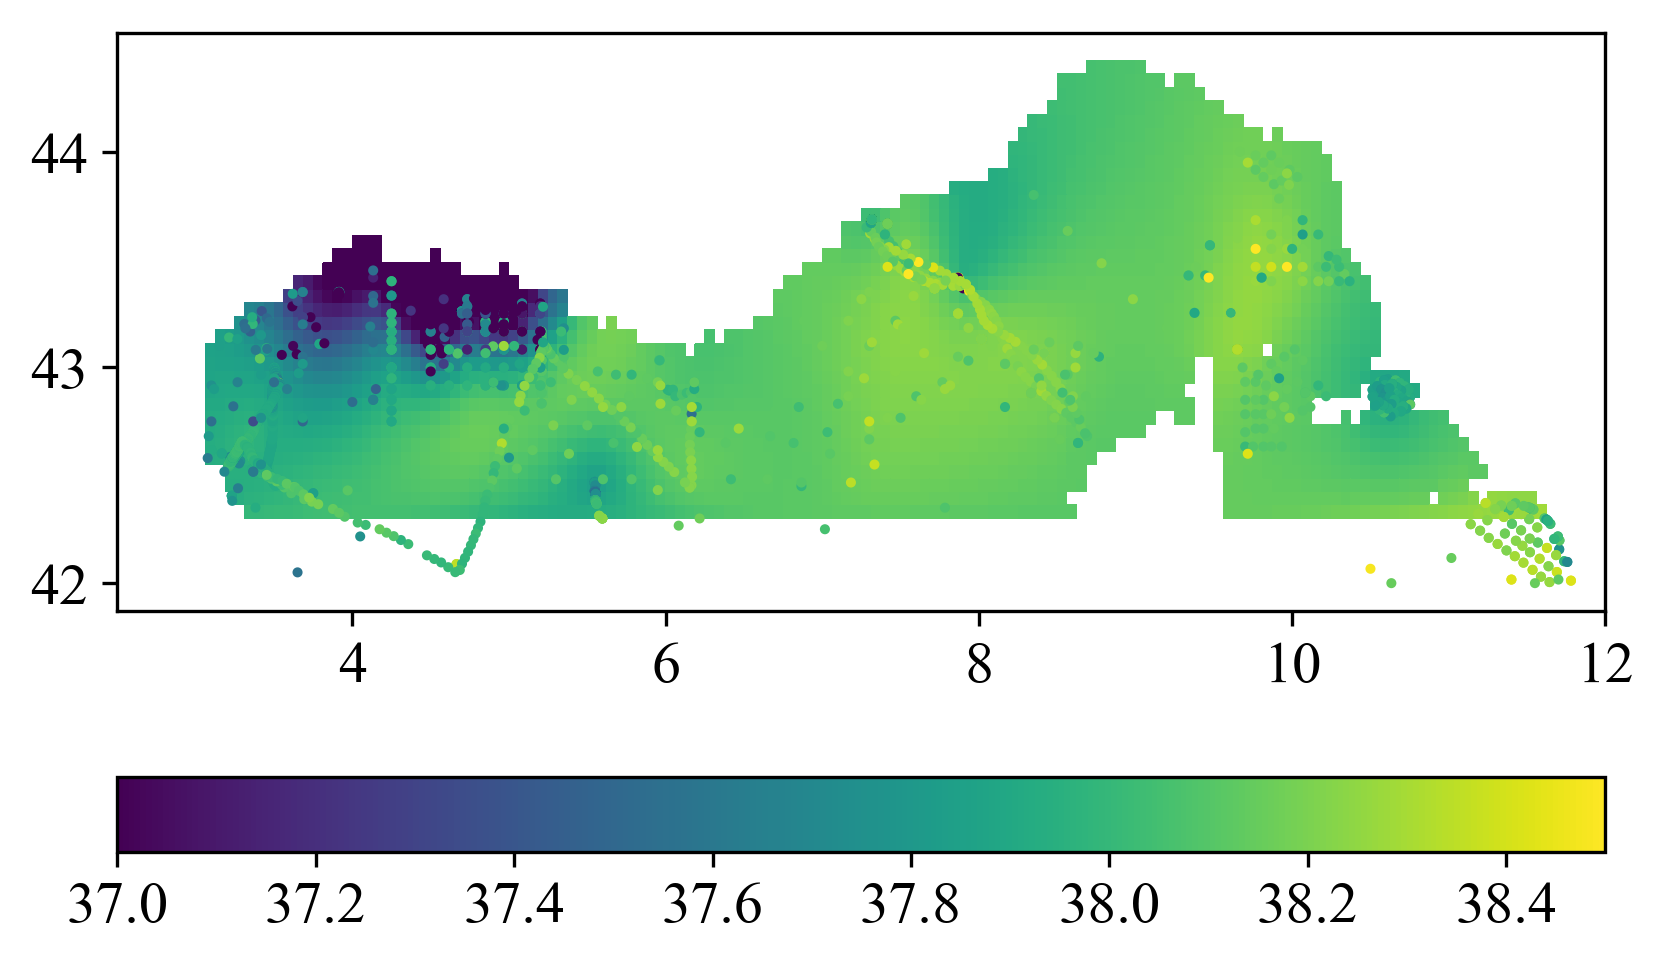

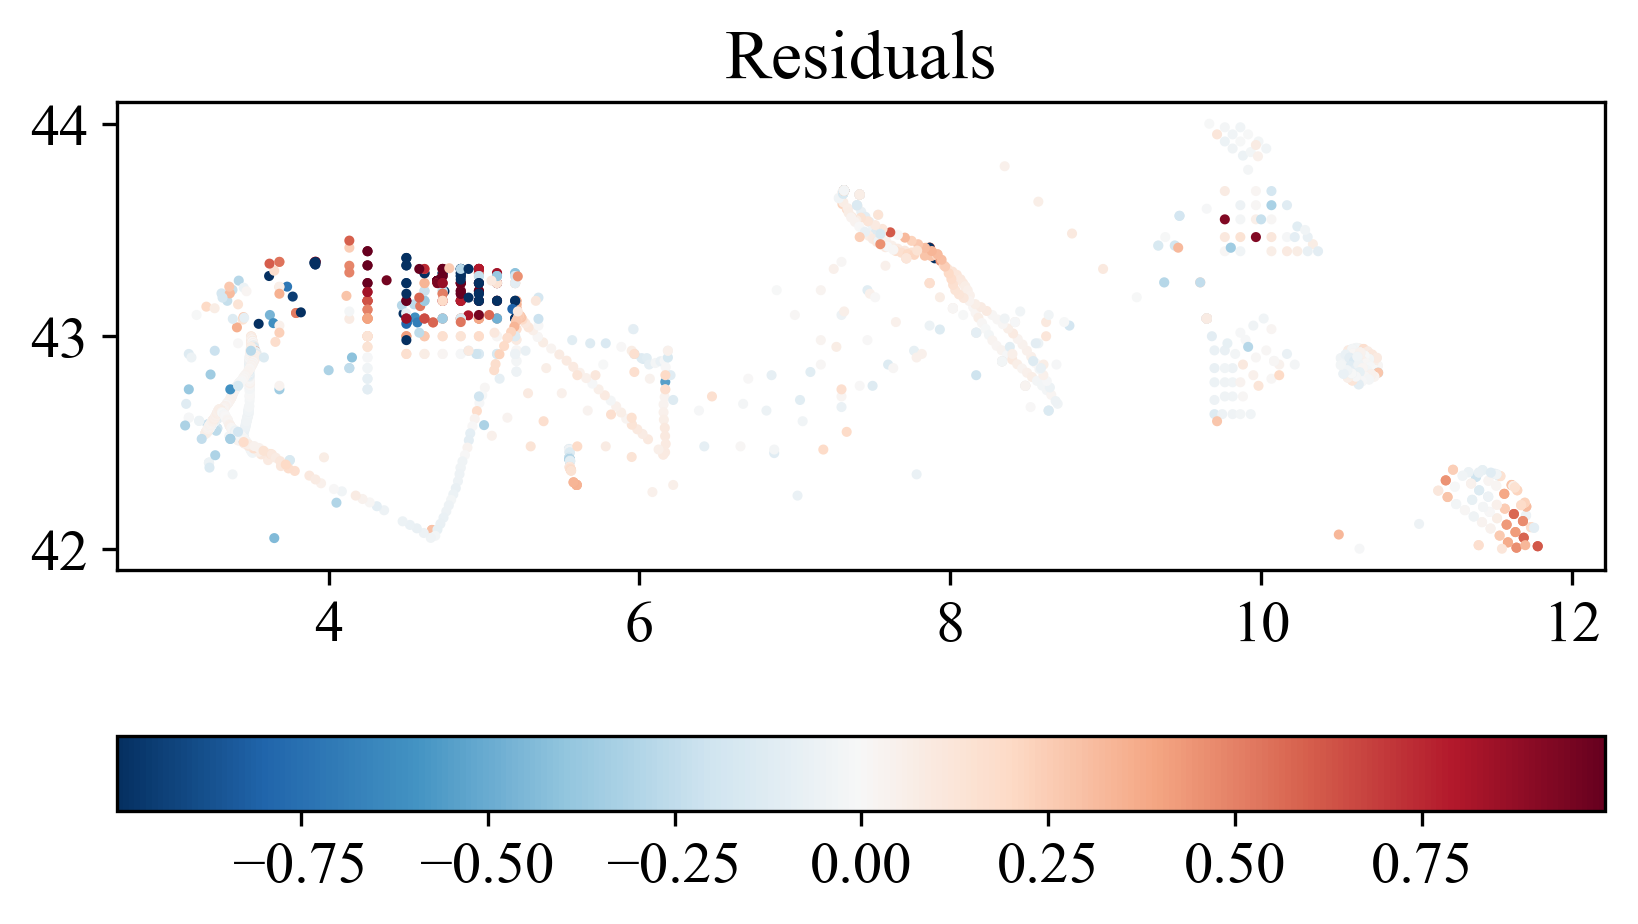

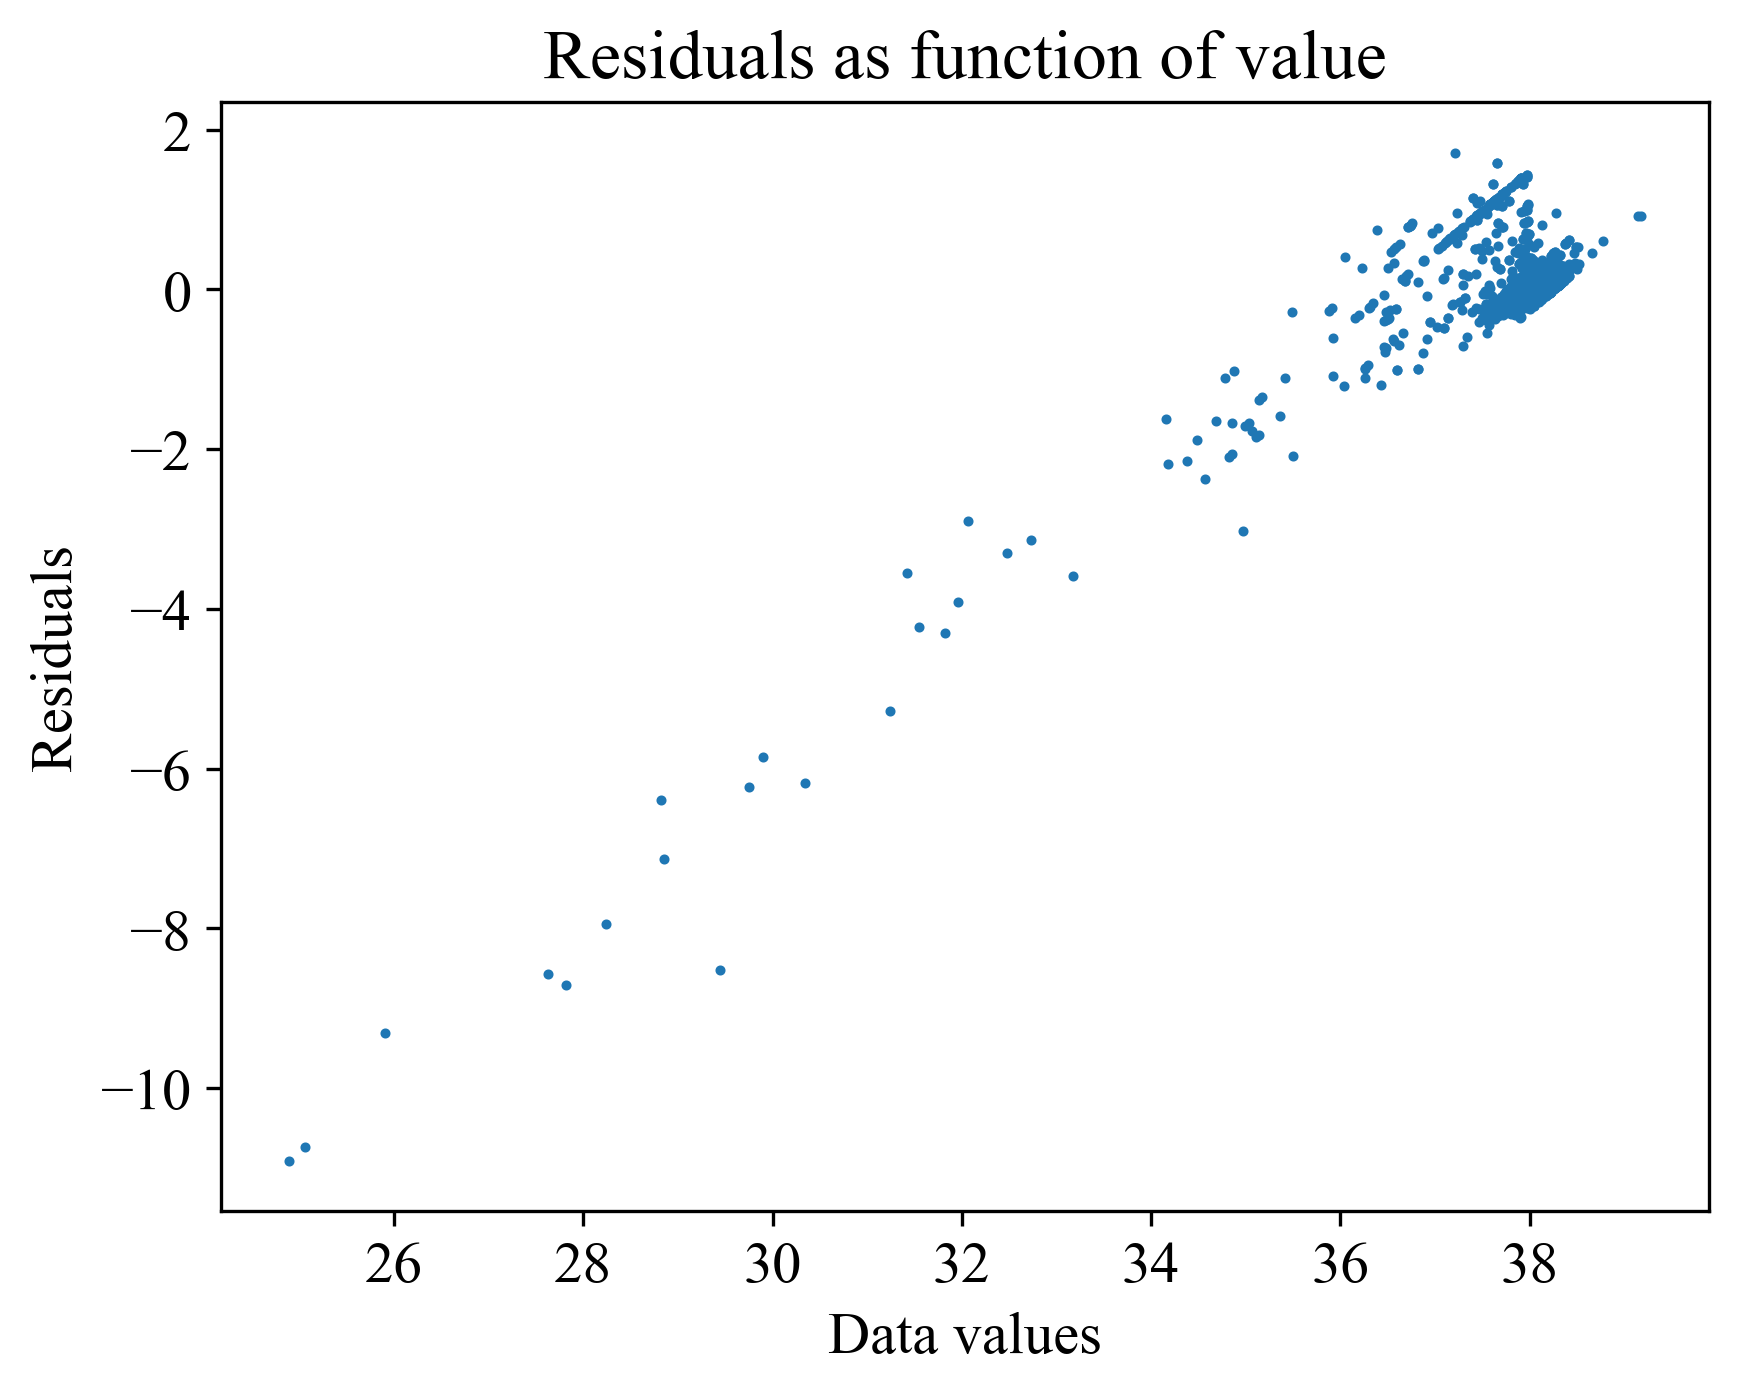

In [16]:
figure()

len=1
epsilon2=1
fi,s = DIVAndrun(mask,(pm,pn),(xi,yi),(obslon,obslat),obsval.-mean(obsval),len,epsilon2);

pcolor(xi,yi,fi.+mean(obsval),vmin=37,vmax=38.5);
colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))
dataresiduals=DIVAnd_residualobs(s,fi)
scatter(obslon,obslat,s=2,c=obsval,vmin=37,vmax=38.5)

rscale=sqrt(var(obsval))

figure()
scatter(obslon,obslat,s=2,c=dataresiduals,vmin=-rscale,vmax=rscale,cmap=ColorMap("RdBu_r"));
colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))
title("Residuals")

figure()
scatter(obsval,dataresiduals, s=2)
xlabel("Data values")
ylabel("Residuals")
title("Residuals as function of value");


Note how residuals change (decrease if you decrease $\epsilon^2$). 

**But beware, low residuals are not necessarily a good sign as the analysis used the data points to which you compare your analysis.**

In [17]:
var(dataresiduals),var(obsval),var(fi[(fi.!==NaN)])

(0.633207266509147, 0.9903466996596086, 0.14484757616112548)

# Exercise

Change parameters $L$ or $\epsilon^2$ and see what happens (do not rerun the whole notebook, just the last cells)

# Important take-home message!
Remember Analyses are not very sensitive to changes in $L$ or $\epsilon^2$ if $L$ $\sqrt{\epsilon^2}$ remains constant. To see changes in the analysis you need significant changes in  $L$ or $\epsilon^2$ changing $L$ $\sqrt{\epsilon^2}$. A few percent changes on the parameters does not really modify things even if $L$ $\sqrt{\epsilon^2}$ changes.